In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import torch
from sklearn.linear_model import LogisticRegression

In [4]:
PATH_TEXT_TRAIN = '/crisis-computing/text-analysis-scripts/additional_files/predictions_full_train_df.csv'
PATH_TEXT_TEST = '/crisis-computing/text-analysis-scripts/additional_files/predictions_test_df.csv'
PATH_IMAGE_TRAIN = '/crisis-computing/ResNet50/predictions_train.csv'
PATH_IMAGE_TEST = '/crisis-computing/ResNet50/predictions_test.csv'

def extract_data():
  """
  returns tweets train and test set, image train and test set
  """
  text_test = pd.read_csv(PATH_TEXT_TEST)

  text_train = pd.read_csv(PATH_TEXT_TRAIN)

  # replaced 1 with 0 and 0 with 1 because model was trained with 0 as Informative and 1 as Non informative
  img_test = pd.read_csv(PATH_IMAGE_TEST)
  img_test['actual_label'].replace([0,1],[1,0], inplace=True)

  img_train = pd.read_csv(PATH_IMAGE_TRAIN)
  img_train['actual_label'].replace([0,1],[1,0], inplace=True)

  return text_train, text_test, img_train, img_test

# call to extract_data
text_train, text_test, img_train, img_test = extract_data()

In [5]:
def generate_train_data(img_train, text_train):
  """
  returns train_data in format ['image_probabilities', 'text_probabilities', 'actual output label']
  params: text_train: text based train dataset
          img_train: image based train dataset
  """
  train_data = pd.DataFrame(columns=["image_prob", "text_prob", 'output'])

  for ind, row in img_train.iterrows():
    t_row = text_train.loc[text_train['tweet_id']==row['tweet_id']]
    prob = pd.Series([row['predicted_probability'], t_row['predictions'].values[0], row['actual_label']],index=train_data.columns)
    train_data = train_data.append(prob, ignore_index=True)
  
  return train_data

# call to generate_train_data
train_data = generate_train_data(img_train, text_train)

In [6]:
def generate_test_data(img_test, text_test):
  """
  returns train_data in format ['image_probabilities', 'text_probabilities', 'actual output label']
  params: text_test: text based test dataset
          img_test: image based test dataset
  """
  test_data = pd.DataFrame(columns=["image_prob", "text_prob", 'output'])

  for ind, row in img_test.iterrows():
    t_row = text_test.loc[text_test['tweet_id']==row['tweet_id']]
    prob = pd.Series([row['predicted_probability'], t_row['predictions'].values[0], row['actual_label']],index=test_data.columns)
    test_data = test_data.append(prob, ignore_index=True)
  
  return test_data

# call to generate_train_data
test_data = generate_test_data(img_test, text_test)

                 precision    recall  f1-score   support

    Informative       0.95      0.92      0.94      1673
Non-Informative       0.87      0.91      0.89       903

       accuracy                           0.92      2576
      macro avg       0.91      0.92      0.91      2576
   weighted avg       0.92      0.92      0.92      2576



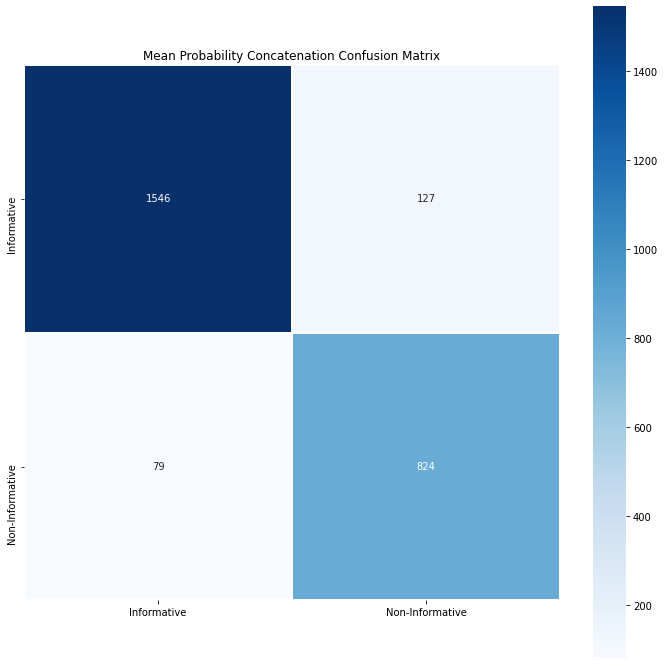

In [29]:
def mean_prob_concatenation(test_data):
  """
   Class prediction probabilities obtained by both textual and visual
   modalities have been combined, averaged and then thresholded
   params: test_data: testing dataset
   returns fused output of image classification and text classification
  """
  fusion_op = (test_data['image_prob'] + test_data['text_prob']).div(2)
  fusion_op[fusion_op>0.5] = 1
  fusion_op[fusion_op<=0.5] = 0

  return fusion_op

def plot_confusion_matrix(actual_data, predicted_data, title):
  """
  Plots confusion matrix of the classified test data and prints various classification metrics
  params: actual_data: true labels of test set
          predicted_data: predicted labels on test set
  """
  classes = ['Informative', 'Non-Informative']
  conf_mat = confusion_matrix(actual_data, predicted_data, labels = [1,0])
  ax = plt.figure(figsize=(12,12))
  plt.title(title)
  sns.heatmap(conf_mat, xticklabels=classes, yticklabels=classes,cmap='Blues', annot=True, fmt='d',
              linewidths=1, square=True)
  print(classification_report(actual_data, predicted_data, labels= [1, 0], target_names=["Informative", "Non-Informative"]))

# call to mean_prob_concatenation method
fusion_op = mean_prob_concatenation(test_data)
plot_confusion_matrix(test_data['output'], fusion_op, "Mean Probability Concatenation Confusion Matrix")

In [31]:
class MLP(torch.nn.Module):
  """
  MLP Architecture
  """
  def __init__(self, input_size=2, hidden_dim=128):
    super(MLP,self).__init__()

    self.model = torch.nn.Sequential(
        torch.nn.Linear(input_size, hidden_dim),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden_dim, 1),
        torch.nn.Sigmoid()
    )

  def forward(self,x):
    output = self.model(x)
    return output

class Dataloader(torch.utils.data.Dataset):
  def __init__(self,data):
    self.feat = data[["image_prob", "text_prob"]]
    self.label = data["output"]
  
  def __len__(self):
    return len(self.label)
  
  def __getitem__(self, idx):
    feat = self.feat.iloc[idx].values
    label = self.label.iloc[idx]
    return feat, label


In [32]:
BATCH_SIZE = 64

def create_dataloaders(train_data, test_data):
  """
  returns train and test data-loaders to perform inference on.
  params: train_data, test_data: train and test data in the format [feat, labels] dataframe.
  """
  train_loader = Dataloader(train_data.astype('float32'))
  test_loader = Dataloader(test_data.astype('float32'))

  train_loader = torch.utils.data.DataLoader(train_loader, shuffle=True, batch_size=BATCH_SIZE, num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_loader, shuffle=True, batch_size=len(test_loader), num_workers=4)

  return train_loader, test_loader

# call to create_dataloaders
train_loader, test_loader = create_dataloaders(train_data, test_data)

Epoch: 1
Train loss: 0.11
------------------------
Epoch: 2
Train loss: 0.09
------------------------
Epoch: 3
Train loss: 0.09
------------------------
Epoch: 4
Train loss: 0.08
------------------------
Epoch: 5
Train loss: 0.09
------------------------
Epoch: 6
Train loss: 0.09
------------------------
Epoch: 7
Train loss: 0.08
------------------------
Epoch: 8
Train loss: 0.08
------------------------
Epoch: 9
Train loss: 0.08
------------------------
Epoch: 10
Train loss: 0.08
------------------------
Epoch: 11
Train loss: 0.08
------------------------
Epoch: 12
Train loss: 0.08
------------------------
Epoch: 13
Train loss: 0.08
------------------------
Epoch: 14
Train loss: 0.08
------------------------
Epoch: 15
Train loss: 0.08
------------------------
Epoch: 16
Train loss: 0.08
------------------------
Epoch: 17
Train loss: 0.08
------------------------
Epoch: 18
Train loss: 0.08
------------------------
Epoch: 19
Train loss: 0.08
------------------------
Epoch: 20
Train loss:

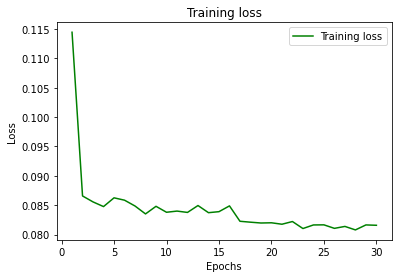

In [33]:
# training params
learning_rate = 0.01
epochs = 30
mlp = MLP().cuda()
mlp.train()
optimizer = torch.optim.Adam(mlp.parameters(), lr = learning_rate, betas=(0.9,0.999))
criterion = torch.nn.BCELoss()
PATH_CKPT = '/content/mlp.pth'

def train_model(epochs, criterion, optimizer, model, train_loader):
  """
  returns loss from training the MLP architecture 
  """
  training_loss = []
  for epoch in range(epochs):
    epoch_loss = 0
    for (feat, label) in train_loader:
      feat = feat.cuda()
      label = label.cuda()
      optimizer.zero_grad()
      output = mlp(feat)
      loss = criterion(output.squeeze(), label)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    epoch_loss/=len(train_loader)
    training_loss.append(epoch_loss)
    print("Epoch: {}".format(epoch+1))
    print("Train loss: {0:.2f}".format(epoch_loss))
    print("------------------------")

  torch.save(mlp.state_dict(), PATH_CKPT)
  print("Training done!")
  return training_loss

def plot_loss(train_loss, epoch):
    """
    plots train loss curve
    """
    epochs = range(1,epoch+1)
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# call to train_model and plot_loss
train_loss = train_model(epochs, criterion, optimizer, mlp, train_loader)
plot_loss(train_loss, epochs)

                 precision    recall  f1-score   support

    Informative       0.94      0.93      0.94      1673
Non-Informative       0.88      0.89      0.88       903

       accuracy                           0.92      2576
      macro avg       0.91      0.91      0.91      2576
   weighted avg       0.92      0.92      0.92      2576



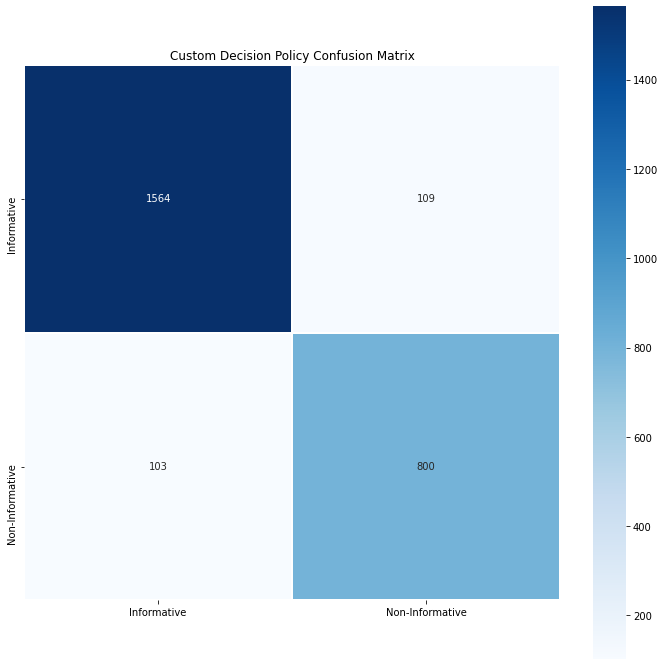

In [34]:
# load stored model
model = MLP().cuda()
model.load_state_dict(torch.load(PATH_CKPT))

def test(model, test_loader):
  """
  performs forward pass on test set.
  """
  model.eval()
  predictions = []
  actual = []
  with torch.no_grad():
    for (feat, label) in test_loader:
      feat = feat.cuda()
      output = model(feat)
      actual = label.cpu()
      predictions = (output.squeeze()>0.5).cpu().float()
      correct = (predictions == label).sum().item()
   
  return actual, predictions 

# call to test the model and get classification metrics
actual_label, predicted_label = test(model, test_loader)
plot_confusion_matrix(actual_label, predicted_label, "Custom Decision Policy Confusion Matrix")

                 precision    recall  f1-score   support

    Informative       0.94      0.92      0.93      1673
Non-Informative       0.86      0.90      0.88       903

       accuracy                           0.92      2576
      macro avg       0.90      0.91      0.91      2576
   weighted avg       0.92      0.92      0.92      2576



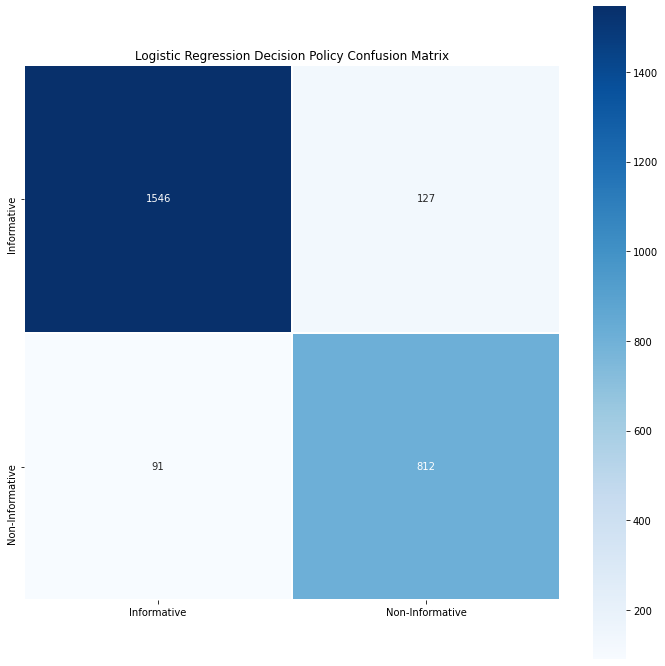

In [35]:
def Logistic_Regression_policy(train_data, test_data):
  """
  Logistic Regression Decision policy for late fusion
  """
  clf = LogisticRegression(random_state=0, solver='newton-cg').fit(train_data[["image_prob","text_prob"]],train_data["output"] )
  predictions = clf.predict(test_data[["image_prob","text_prob"]])
  correct = (predictions == test_data['output']).sum()
  
  return test_data['output'], predictions

# call to Logistic Regression decision policy
actual_label, predicted_label = Logistic_Regression_policy(train_data, test_data)
plot_confusion_matrix(actual_label, predicted_label, "Logistic Regression Decision Policy Confusion Matrix")